# Models Comparison for TinyML

In [53]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [54]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [55]:
data = ['../data/X-intensity.pkl', '../data/X-all.pkl', '../data/X-10-25.pkl', '../data/X-1-2.pkl', '../data/X-25_50-50_25.pkl', '../data/X-100-150-200.pkl']
labels = ['../data/y-intensity.pkl', '../data/y-all.pkl', '../data/y-10-25.pkl', '../data/y-1-2.pkl', '../data/y-25_50-50_25.pkl', '../data/y-100-150-200.pkl']
choosenIndex = 5
tasks = ['intensity', 'all','10-25','1-2', '25-50', '100-200']
with open(data[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(labels[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [56]:
if choosenIndex == 1:
    X = X[165:-13]
    y = y[165:-13]
if choosenIndex == 2:
    X = X[146:-13]
    y = y[146:-13]
if choosenIndex == 3:
    X = X[101:-13]
    y = y[101:-13]

In [57]:
print(X.shape)

(4666, 60)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
uniques = np.unique(y)

In [59]:
#Altrimenti il testSet viene troppo lungo e impossibile da caricare
if choosenIndex == 1 or choosenIndex == 5:
    half = X_test.shape[0] // 2
    X_test = X_test[:half, :]
    y_test = y_test[:half]
print(X_test)
print(y_test)

[[ 0.04  0.12  0.96  0.01  0.03  1.01 -0.    0.1   0.99 -0.02  0.01  0.97
  -0.02  0.08  0.97  0.05  0.13  0.98 -0.01  0.08  0.98  0.01  0.11  0.96
  -0.04  0.06  0.99 -0.03  0.11  0.95 -0.01  0.12  0.98  0.    0.08  0.96
  -0.03  0.06  0.95  0.04  0.1   0.99  0.03  0.08  0.99  0.03  0.1   0.96
   0.01  0.09  1.   -0.01  0.08  1.01 -0.03  0.04  1.03 -0.04  0.07  0.97]
 [ 0.06  0.13  0.98 -0.01  0.09  0.97 -0.07  0.09  0.95 -0.01  0.07  0.95
   0.03  0.13  0.97 -0.04  0.06  0.98  0.05  0.12  0.99  0.01  0.07  0.98
  -0.03  0.12  0.98 -0.03  0.06  0.96  0.01  0.07  0.99  0.03  0.09  1.01
  -0.02  0.07  0.96 -0.03  0.04  0.99 -0.01  0.08  1.02 -0.05  0.02  0.97
   0.02  0.11  0.95 -0.02  0.11  0.95 -0.    0.1   1.02 -0.03  0.12  0.94]
 [ 0.    0.01  1.02  0.02  0.01  0.96  0.1   0.04  0.99 -0.02 -0.03  0.94
   0.02 -0.    0.98  0.02  0.01  1.    0.04 -0.02  0.93  0.05  0.    0.94
  -0.03 -0.01  0.98 -0.01  0.01  1.02  0.08  0.    0.91  0.02  0.03  1.
   0.02  0.01  0.99  0.02 -0.    0.98 

## Model Spotting

In [60]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [61]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR',  LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [62]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 1,00 0,00
LR - 1,00 0,00
CART - 0,99 0,00
SVC - 1,00 0,00
RF - 1,00 0,00


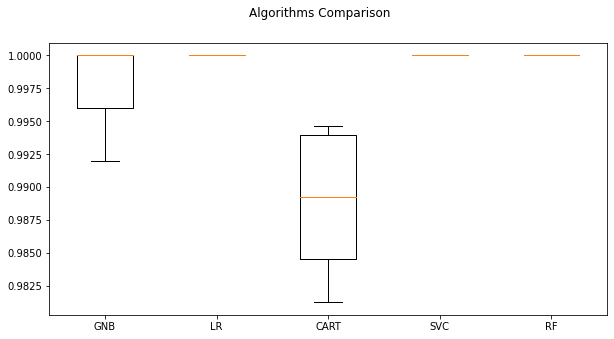

In [63]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [64]:

def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports'+ '/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       292
           1       1.00      1.00      1.00       282
           2       1.00      0.99      1.00       360

    accuracy                           1.00       934
   macro avg       1.00      1.00      1.00       934
weighted avg       1.00      1.00      1.00       934

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       1.00      1.00      1.00       282
           2       1.00      1.00      1.00       360

    accuracy                           1.00       934
   macro avg       1.00      1.00      1.00       934
weighted avg       1.00      1.00      1.00       934

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.99

# Neural Network

In [65]:
def getNetwork():
    n = 50
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [66]:
EPOCHS = 100
BATCH_SIZE = 10
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_4 (Dense)              (None, 150)               9150      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 453       
Total params: 13,263
Trainable params: 13,263
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
336/336 [==============================] - 0s 603us/step - loss: 1.0397 - accuracy: 0.4279
Epoch 2/100
336/336 [==============================] - 0s 371us/step - loss: 0.8056 - accuracy: 0.9780
Epoch 3/100
336/336 [==============================] - 0s 362us/step - loss: 0.4531 - accuracy: 0.9994
Epoch 4/100
336/336 [==============================] - 0s 394us/step -

336/336 [==============================] - 0s 392us/step - loss: 5.9000e-06 - accuracy: 1.0000
Epoch 40/100
336/336 [==============================] - 0s 388us/step - loss: 4.9633e-06 - accuracy: 1.0000
Epoch 41/100
336/336 [==============================] - 0s 380us/step - loss: 4.1657e-06 - accuracy: 1.0000
Epoch 42/100
336/336 [==============================] - 0s 387us/step - loss: 3.4921e-06 - accuracy: 1.0000
Epoch 43/100
336/336 [==============================] - 0s 382us/step - loss: 2.9159e-06 - accuracy: 1.0000
Epoch 44/100
336/336 [==============================] - 0s 379us/step - loss: 2.5332e-06 - accuracy: 1.0000
Epoch 45/100
336/336 [==============================] - 0s 362us/step - loss: 2.0886e-06 - accuracy: 1.0000
Epoch 46/100
336/336 [==============================] - 0s 370us/step - loss: 1.7566e-06 - accuracy: 1.0000
Epoch 47/100
336/336 [==============================] - 0s 374us/step - loss: 1.4887e-06 - accuracy: 1.0000
Epoch 48/100
336/336 [===================

336/336 [==============================] - 0s 594us/step - loss: 1.0753e-08 - accuracy: 1.0000
Epoch 85/100
336/336 [==============================] - 0s 576us/step - loss: 9.6886e-09 - accuracy: 1.0000
Epoch 86/100
336/336 [==============================] - 0s 624us/step - loss: 8.5530e-09 - accuracy: 1.0000
Epoch 87/100
336/336 [==============================] - 0s 631us/step - loss: 8.4465e-09 - accuracy: 1.0000
Epoch 88/100
336/336 [==============================] - 0s 645us/step - loss: 8.6949e-09 - accuracy: 1.0000
Epoch 89/100
336/336 [==============================] - 0s 762us/step - loss: 6.6365e-09 - accuracy: 1.0000
Epoch 90/100
336/336 [==============================] - 0s 577us/step - loss: 6.5301e-09 - accuracy: 1.0000
Epoch 91/100
336/336 [==============================] - 0s 566us/step - loss: 6.6010e-09 - accuracy: 1.0000
Epoch 92/100
336/336 [==============================] - 0s 576us/step - loss: 5.8913e-09 - accuracy: 1.0000
Epoch 93/100
336/336 [===================

336/336 [==============================] - 0s 351us/step - loss: 2.1146e-04 - accuracy: 1.0000
Epoch 23/100
336/336 [==============================] - 0s 353us/step - loss: 1.7148e-04 - accuracy: 1.0000
Epoch 24/100
336/336 [==============================] - 0s 350us/step - loss: 1.3982e-04 - accuracy: 1.0000
Epoch 25/100
336/336 [==============================] - 0s 343us/step - loss: 1.1447e-04 - accuracy: 1.0000
Epoch 26/100
336/336 [==============================] - 0s 349us/step - loss: 9.4022e-05 - accuracy: 1.0000
Epoch 27/100
336/336 [==============================] - 0s 347us/step - loss: 7.6972e-05 - accuracy: 1.0000
Epoch 28/100
336/336 [==============================] - 0s 351us/step - loss: 6.4068e-05 - accuracy: 1.0000
Epoch 29/100
336/336 [==============================] - 0s 350us/step - loss: 5.2437e-05 - accuracy: 1.0000
Epoch 30/100
336/336 [==============================] - 0s 359us/step - loss: 4.3486e-05 - accuracy: 1.0000
Epoch 31/100
336/336 [===================

Epoch 98/100
336/336 [==============================] - 0s 349us/step - loss: 4.4007e-09 - accuracy: 1.0000
Epoch 99/100
336/336 [==============================] - 0s 347us/step - loss: 4.2942e-09 - accuracy: 1.0000
Epoch 100/100
336/336 [==============================] - 0s 346us/step - loss: 4.1168e-09 - accuracy: 1.0000
Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_19 (Dense)             (None, 150)               9150      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 453       
Total params: 13,263
Trainable params: 13,263
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
336/336 [==============================] -

336/336 [==============================] - 0s 359us/step - loss: 1.4524e-05 - accuracy: 1.0000
Epoch 37/100
336/336 [==============================] - 0s 354us/step - loss: 1.2321e-05 - accuracy: 1.0000
Epoch 38/100
336/336 [==============================] - 0s 353us/step - loss: 1.0242e-05 - accuracy: 1.0000
Epoch 39/100
336/336 [==============================] - 0s 352us/step - loss: 8.6508e-06 - accuracy: 1.0000
Epoch 40/100
336/336 [==============================] - 0s 351us/step - loss: 7.0358e-06 - accuracy: 1.0000
Epoch 41/100
336/336 [==============================] - 0s 348us/step - loss: 6.0261e-06 - accuracy: 1.0000
Epoch 42/100
336/336 [==============================] - 0s 353us/step - loss: 5.0355e-06 - accuracy: 1.0000
Epoch 43/100
336/336 [==============================] - 0s 352us/step - loss: 4.1572e-06 - accuracy: 1.0000
Epoch 44/100
336/336 [==============================] - 0s 355us/step - loss: 3.5543e-06 - accuracy: 1.0000
Epoch 45/100
336/336 [===================

336/336 [==============================] - 0s 532us/step - loss: 1.4160e-08 - accuracy: 1.0000
Epoch 82/100
336/336 [==============================] - 0s 522us/step - loss: 1.2492e-08 - accuracy: 1.0000
Epoch 83/100
336/336 [==============================] - 0s 528us/step - loss: 1.3202e-08 - accuracy: 1.0000
Epoch 84/100
336/336 [==============================] - 0s 523us/step - loss: 1.0363e-08 - accuracy: 1.0000
Epoch 85/100
336/336 [==============================] - 0s 529us/step - loss: 1.0115e-08 - accuracy: 1.0000
Epoch 86/100
336/336 [==============================] - 0s 532us/step - loss: 9.6177e-09 - accuracy: 1.0000
Epoch 87/100
336/336 [==============================] - 0s 526us/step - loss: 8.3400e-09 - accuracy: 1.0000
Epoch 88/100
336/336 [==============================] - 0s 528us/step - loss: 7.9851e-09 - accuracy: 1.0000
Epoch 89/100
336/336 [==============================] - 0s 520us/step - loss: 7.3463e-09 - accuracy: 1.0000
Epoch 90/100
336/336 [===================

336/336 [==============================] - 0s 372us/step - loss: 3.7209e-04 - accuracy: 1.0000
Epoch 20/100
336/336 [==============================] - 0s 349us/step - loss: 3.0262e-04 - accuracy: 1.0000
Epoch 21/100
336/336 [==============================] - 0s 375us/step - loss: 2.4464e-04 - accuracy: 1.0000
Epoch 22/100
336/336 [==============================] - 0s 351us/step - loss: 2.0017e-04 - accuracy: 1.0000
Epoch 23/100
336/336 [==============================] - 0s 357us/step - loss: 1.6329e-04 - accuracy: 1.0000
Epoch 24/100
336/336 [==============================] - 0s 363us/step - loss: 1.3481e-04 - accuracy: 1.0000
Epoch 25/100
336/336 [==============================] - 0s 351us/step - loss: 1.1073e-04 - accuracy: 1.0000
Epoch 26/100
336/336 [==============================] - 0s 357us/step - loss: 9.1328e-05 - accuracy: 1.0000
Epoch 27/100
336/336 [==============================] - 0s 351us/step - loss: 7.5424e-05 - accuracy: 1.0000
Epoch 28/100
336/336 [===================

Epoch 95/100
336/336 [==============================] - 0s 353us/step - loss: 4.9685e-09 - accuracy: 1.0000
Epoch 96/100
336/336 [==============================] - 0s 355us/step - loss: 4.5072e-09 - accuracy: 1.0000
Epoch 97/100
336/336 [==============================] - 0s 352us/step - loss: 4.4007e-09 - accuracy: 1.0000
Epoch 98/100
336/336 [==============================] - 0s 354us/step - loss: 4.0458e-09 - accuracy: 1.0000
Epoch 99/100
336/336 [==============================] - 0s 351us/step - loss: 3.9393e-09 - accuracy: 1.0000
Epoch 100/100
336/336 [==============================] - 0s 353us/step - loss: 3.5490e-09 - accuracy: 1.0000
Average score of Cross Validation: 1.0


# Train and Test

In [67]:
EPOCHS = 100
BATCH_SIZE = 10
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_34 (Dense)             (None, 150)               9150      
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 453       
Total params: 13,263
Trainable params: 13,263
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
280/280 [==============================] - 0s 614us/step - loss: 0.9995 - accuracy: 0.5634 - val_loss: 0.8942 - val_accuracy: 0.6956
Epoch 2/100
280/280 [==============================] - 0s 452us/step - loss: 0.7557 - accuracy: 0.9603 - val_loss: 0.5893 - val_accuracy: 0.9989
Epoch 3/100
280/280 [==============================] - 0s 446us/step - loss: 0.4387 - acc

# Export Models in C code

In [68]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=False))

INFO:tensorflow:Assets written to: /tmp/tmpkophdomo/assets


INFO:tensorflow:Assets written to: /tmp/tmpkophdomo/assets


# Valutazione Inferance Rate medio (Intensità)

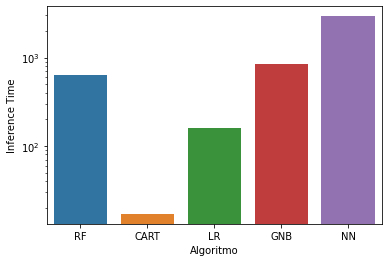

In [69]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

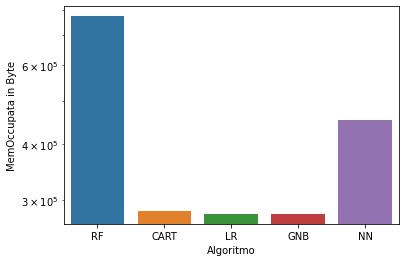

In [70]:
csv = read_csv("MemOccupationReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
g.set_yscale('log')
plt.ylabel("MemOccupata in Byte")
plt.show()
# SVC in overflow